---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Credit Card fraud detection

In the current project, we will address the issue of credit card frauds, which is considered to be a form of identity theft. Typically, this type of fraud occurs from the illegal charging of purchases or funds removal from another's account due to unauthorised use of the person's credit card information<sup><a href="https://www.law.cornell.edu/wex/credit_card_fraud">1</a></sup>. This type of fraud is a major cause of concern in financial institutions and fintechs globally. According to the Nilson Report, credit card fraud worldwide led to the loss of $28.58 billion in 2020<sup><a href="https://nilsonreport.com/mention/1515/1link/">2</a></sup>.

<p align=center>
<img src="img/cctheft.jpg" width="50%"><br>
<i><sup>Image credits: kjpargeter (<a href="https://www.freepik.com/search?author=938508&authorSlug=kjpargeter&format=author&selection=1">www.freepik.com</a>)</sup></i>
</p>

Thus, credit card frauds are greatly relevant due to their potential to considerably harm both costumers and financial institutions. Another factor to be taken into account are the action to preventively block a credit card due to suspicious activity. If the transaction is genuine, this causes both stress and embarassment to the clients who are denied their purchase.

For the aforementioned reasons, investments in Fraud Detection through Artificial Inteligence are increasing constantly, presenting as a great Data Science oportunity. Slightly better machine learning algorithms, with great volumes of data as a base, already represent millions in economy through fraud avoidance.

## Getting the data

The data that we are using in this project is available on the [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) website. It consists of anonymized credit card transactions, which were labeled as fraudulent or genuine transactions. 

The dataset actually consists of credit card transactions registered in September 2013 by cardholders in Europe. It represents transactions made over the course of two days, where **492 frauds** were identified, out of 284,807 transactions. In total, the operations marked as fraudulent represent only 0.172% of the total dataset, making this dataset highly unbalanced<sup><a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">3</a></sup>.

<p align=center>
<img src="img/ccpayment.jpg" width="50%"><br>
<i><sup>Image credits: freepik (<a href="https://www.freepik.com/free-photo/person-paying-with-its-credit-card_20083164.htm">www.freepik.com</a>)</sup></i>
</p>

In addition, the source informs that the dataset has been through a dimensionality reduction transformation: the Principal Component Analysis (PCA). This was done to protect user identities and other sensitive features in the dataset, while also reducing its complexity.

With the increase in the number of variables in a given dataset, the difficulty to visualize a multi-dimensional hyperspace also increases. The goal of the PCA is to extract important information from this multi-variate data that are inter-correlated. While each variable is considered a different *dimension*, the PCA extracts the information in the dataset as a set of new variables called **principal components**, reducing the number of *dimensions* from the original dataset. These **principal components** correspond to a linear combination of the original variables and their goal is to encapsulate most of the variation present in the dataset<sup><a href="http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/">4</a></sup>.

In our dataset, the **principal components** correspond to the columns in the dataset: $[V1, V2, V3 \dots, Vn]$.

### Loading necessary packages

In [2]:
## Importing packages

# General
import pandas as pd
import numpy as np
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Machine Learning models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# Tool for dealing with imbalance
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

### Importing the data

For ease of access, since this is a bigger file, we will import it as a direct access link.

In [3]:
file_path = "https://onedrive.live.com/download?cid=A06C4A8AAF3A347B&resid=A06C4A8AAF3A347B%215208&authkey=AAdhamfzp5RS9PM"

# Downloading and reading the file
df = pd.read_csv(file_path)

Now, let's verify basic characteristics of our dataset and subset the `test` data that is going to be used later on.

In [4]:
# Original size
print('Original size of the dataset: ', df.shape[0], ' entries.')

# Separating test data
test = df.sample(frac=0.15, random_state=42)

# Removing test data from regular df
df = df.drop(test.index)

# Test dataset size
print('Test dataset size: ', test.shape[0], ' entries.')
print('Remaining dataset size: ', df.shape[0], ' entries.')

Original size of the dataset:  284807  entries.
Test dataset size:  42721  entries.
Remaining dataset size:  242086  entries.


Having imported the data, we can begin the exploratory analysis of the dataset while also preparing the data to use in a **machine learning** model.

## Exploratory analysis

To begin our analysis, let us look a the first entries of the dataframe:

From this initial look, we can see that our data is entirely numeric after the dimensionality reduction (the *Principal Component Analysis*). Follow [this link](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) if you want to know more about the method.

The only values that were preserved were the columns:
* `Time`: Number of seconds elapsed between this transaction and the first transaction in the dataset;
* `Amount`: Value that represents the transaction amount;
* `Class`: Binary coded variable, with '1' representing fraudulent transactions and '0' representing regular ones.

Now, let us do descriptive statistics on the dataset and check if there are any missing values:

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,...,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000
mean,94790.585432,0.001153,-0.000866,-0.000249,-0.000743,-0.000391,-0.000532,0.000951,-0.000115,0.000864,...,0.000640,-0.000997,-0.000196,0.000017,-0.000824,-0.000040,-0.000628,0.000409,88.612138,0.001727
std,47488.557251,1.956206,1.653385,1.513529,1.414942,1.384288,1.334177,1.239964,1.189191,1.097059,...,0.733873,0.725555,0.630782,0.605192,0.521516,0.482538,0.402632,0.331341,254.851246,0.041517
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000,0.000000
25%,54156.000000,-0.920932,-0.598121,-0.890516,-0.848834,-0.690313,-0.768634,-0.552487,-0.208175,-0.642411,...,-0.228369,-0.543000,-0.161417,-0.354494,-0.317682,-0.327258,-0.070913,-0.052945,5.560000,0.000000
50%,84676.000000,0.018265,0.065809,0.179657,-0.019657,-0.055903,-0.274238,0.041138,0.022436,-0.050819,...,-0.029438,0.005658,-0.010732,0.040809,0.014962,-0.052117,0.001301,0.011338,22.000000,0.000000
75%,139309.000000,1.315404,0.803877,1.025325,0.742531,0.610267,0.397241,0.570192,0.327822,0.598923,...,0.186394,0.527999,0.148084,0.439855,0.350598,0.241024,0.091082,0.078298,77.290000,0.000000
max,172792.000000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [6]:
# Checking for null values
df.isnull().sum().max()

0

As we can see, we have no columns that contain missing values in our dataset, as indicated above. As for our numeric data, we can already see that we have possible outliers, indicated by min/max values that are distant from the mean or median of the variables. Before checking the outliers, let's see how (un)balanced our dataset is.

0    241668
1       418
Name: Class, dtype: int64

These frauds represent 0.1727% of the dataset.



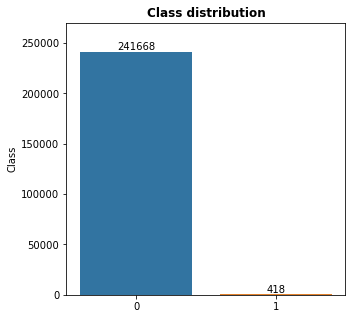

In [7]:
# Count class values
print(df.Class.value_counts())

# How much %? Does it match the number stated by the provider?
print('\nThese frauds represent {:.4f}% of the dataset.\n'.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# Plotting barplot
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=df.Class.unique(), y=df.Class.value_counts(), data=df, ax=ax)
ax.set_title('Class distribution', fontsize=12, weight='bold')
ax = plt.gca()
ax.set_ylim([0, 270000])
ax.bar_label(ax.containers[0]);


To further investigate the presence of outliers and other features of the dataset, we will look at some plots, namely histograms of the `time` and `amount` variables either from normal or fraudulent transactions separately and a boxplot of `amount` in fraudulent transactions.

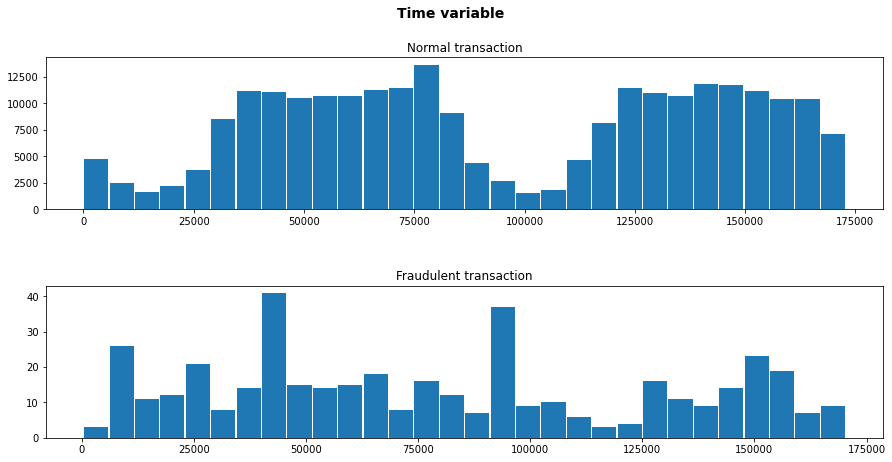

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

axes[0].hist(df.Time[df.Class==0], bins=30, rwidth=0.95)
axes[0].set_title('Normal transaction', fontsize=12)
counts, bins, bars = axes[1].hist(df.Time[df.Class==1], bins=30, rwidth=0.95)
axes[1].set_title('Fraudulent transaction', fontsize=12)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('Time variable', fontsize=14, weight='bold');


In [9]:
# Estimating how much time between the peaks in transactions
timeHistDict = dict(zip(counts, bins))

keys = list(timeHistDict.keys())
keys.sort(reverse=True)
keys = keys[0:2]

count = 1

for key in keys:

    print('Peak #' + str(count) + ' occurs after around ' + str(int(round(timeHistDict.get(key),0))) + ' seconds, or, roughly, around ' + str(int(round(timeHistDict.get(key)/3600,0))) + ' hours after the first transaction.')
    count += 1


Peak #1 occurs after around 40059 seconds, or, roughly, around 11 hours after the first transaction.
Peak #2 occurs after around 91042 seconds, or, roughly, around 25 hours after the first transaction.


From the time data, we can see that normal transactions occur in a continuous pattern over two periods (represented by the broad peaks in the first histogram) of time. These probably represent "regular" day hours, where we would expect most people to be actively making purchases. However, we lack information about the actual time of the transactions and are unable to conclude any further.

Although we can estimate how much time elapse between the peaks in transaction frauds, without the information mentioned above we cannot say what time of day these frauds were more frequent. However, if the broad peaks do represent daytime activity, the second peak in fraudulent transactions could represent operations being made at night which are, potentially, transactions which would take some time before alarming the owner of the credit card, considering most people are sleeping at nighttime.

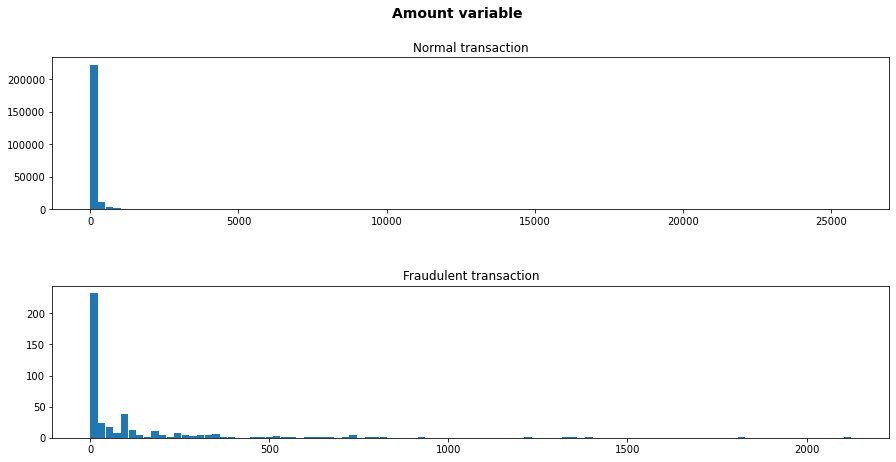

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

axes[0].hist(df.Amount[df.Class==0], bins=100, rwidth=0.95)
axes[0].set_title('Normal transaction', fontsize=12)
axes[1].hist(df.Amount[df.Class==1], bins=100, rwidth=0.95)
axes[1].set_title('Fraudulent transaction', fontsize=12)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('Amount variable', fontsize=14, weight='bold');

As we can see in the histograms for the `amount` variable, regular transactions do not appear to have outliers as most of the data falls around one peak in value. However, for fraudulent transations, we have an increased span of values, up to over $2000. Let us see how these features look in boxplots:

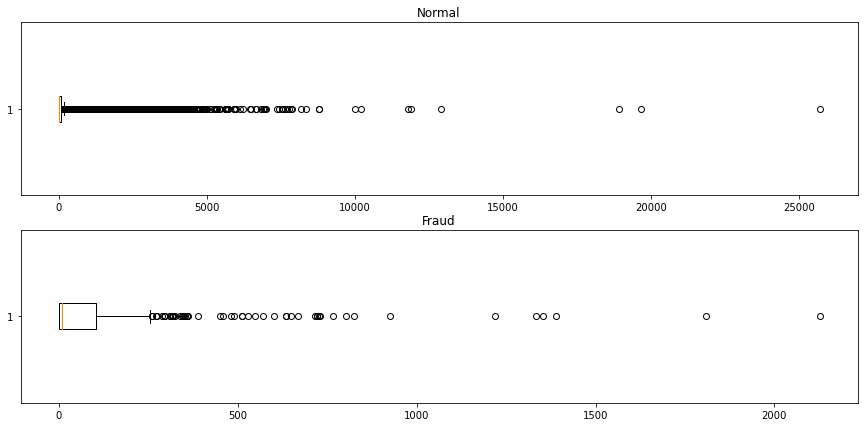

In [11]:
# Plotting boxplots
fig, axes = plt.subplots(2, 1, figsize=(15,7))

axes[0].boxplot(df.Amount[df.Class==0], vert=False)
axes[0].set_title("Normal")
axes[1].boxplot(df.Amount[df.Class==1], vert=False)
axes[1].set_title("Fraud");


From this, we can see that normal transactions also have outliers. However, in both cases these transactions represent real data. This is important, as machine learning techniques have to take these characteristics into account when predicting fraudulent transactions from regular ones.

For now, in summary, we know that the dataset is heavily unbalanced and that `Time` and `Amount` variables are not standardized. Since we are dealing with a PCA transformation, we assume that the features have been standardized beforehand. As for the *unbalancing* of the dataset, it has been previously demonstrated that **class imbalance** is not always a problem for classifiers *per se*<sup><a href="https://www.researchgate.net/profile/Duke-Taeho-Jo/publication/220520142_Class_imbalances_versus_small_disjuncts/links/53fe8cf40cf21edafd151816/Class-imbalances-versus-small-disjuncts.pdf">5</a></sup>. Thus, we will test how the imbalance will impact our models.

## Data preparation

### Feature scaling/data standardization

Since `Time` and `Amount` represent two very different types of measurement, these variables are in different scales. Since the variables have outliers, we will apply the **standardization** (or Z-score transformation) technique before splitting the dataset.

In [12]:
# Copying df
df_std = df.copy()

# Defining scaler
std_scaler = StandardScaler()

# Standardizing and droping old vars
df_std['Std_Time'] = std_scaler.fit_transform(df_std['Time'].values.reshape(-1, 1))
df_std['Std_Amount'] = std_scaler.fit_transform(df_std['Amount'].values.reshape(-1, 1))

df_std.drop(['Time', 'Amount'], axis=1, inplace=True)

In [13]:
# Checking new vars
df_std[['Std_Time', 'Std_Amount']].describe()

,Std_Time,Std_Amount
count,2.420860e+05,2.420860e+05
mean,-1.490656e-17,3.658275e-16
std,1.000002e+00,1.000002e+00
min,-1.996076e+00,-3.477021e-01
25%,-8.556729e-01,-3.258854e-01
50%,-2.129904e-01,-2.613771e-01
75%,9.374575e-01,-4.442655e-02
max,1.642534e+00,1.004610e+02


Now that the variables are transformed, let us split our dataset into train and test data. Since we are using an imbalanced dataset, it is recommended to use a *stratified sampling* approach to splitting the dataset to preserve relative class frequencies<sup><a href="https://scikit-learn.org/stable/modules/cross_validation.html#stratification">6</a></sup>. After that, we will also implement an approach to rebalance the dataset (while also preserving the original data) to test the influence it will have on our models.

In [14]:
# Extracting target
y = df_std['Class']
X = df_std.drop('Class', axis=1)

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

To verify wether or not the imbalance in the dataset actually represents and issue for classifying fraudulent transactions, we will employ a method called **Random Under Sampling** (RUS), from the *imbalanced-learn* library, to balance the dataset. This method works by randomly selecting samples from our default (normal transactions) class to match the number of samples in our class of interest (fraud), which is the minority class in the dataset.

0    313
1    313
Name: Class, dtype: int64


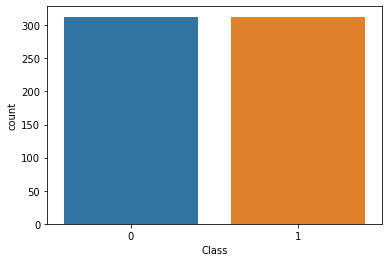

In [15]:
# Defining random under sampler
rus = RandomUnderSampler()

# Creating new train sets
X_under, y_under = rus.fit_resample(X_train, y_train)

# Checking the balancing
print(y_under.value_counts())
sns.countplot(x=y_under);

Now that we have successfully balanced our dataset, let's look at a correlation plot to see how this affected the relationship between the features.

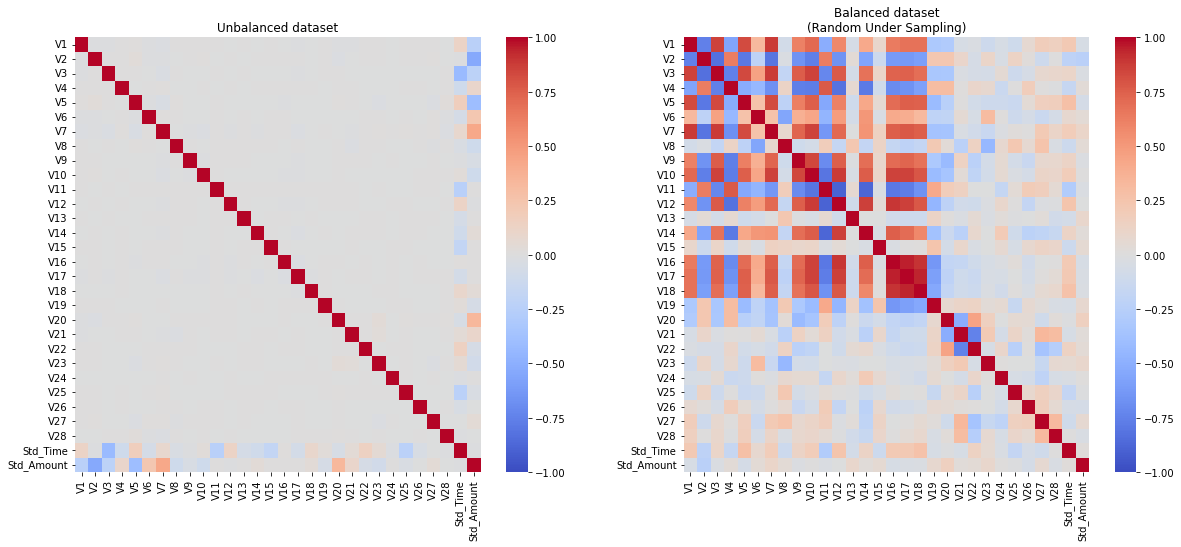

In [16]:
# Calculating correalations
corr = X_train.corr()
corr_under = X_under.corr()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20,8))

axes[0].set_title('Unbalanced dataset')
sns.heatmap(corr, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Balanced dataset\n(Random Under Sampling)')
sns.heatmap(corr_under, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1);



We can see that over half of our features acquire some correlation after filtering the dataset. In addition, some of the correlations (even if weaker ones) in the variables `Amount` and `Time` change after rebalancing the dataset, indicating that this is not a good way of evaluating the relationship between these variables and the features of our dataset.

Still, we will use our machine learning model to determine wether or not it is better to balance the dataset in this case.

## Machine Learning model

Now we will build a model to ***classify*** our data wether they represent fraudulent transactions or not. Since we are talking about a *binary* outcome, one of the models that are suited to this classification is the **binary Logistic Regression**. Another model useful for classification is the *Random Forest* classifier. Here, we will test both these models.

### Logistic Regression

This type of regression, also called logit model or logit regression, is often used to classify or predict an outcome. Speaking simply, it works by estimating the **probability** of occurrence of an event, base on one or more independent variables (also termed *predictors*)<sup><a href="https://www.ibm.com/topics/logistic-regression">6</a></sup>.

Now, we will build two models: one using the unbalanced dataset, and another using the balanced dataset after the [RUS](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) approach.

#### Building the *unbalanced* model

In [17]:
# Setting seed
np.random.seed(42)

# Creating and training the Unbalanced Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting using this model
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

#### Building the *balanced* model

In [18]:
# Setting seed
np.random.seed(42)

# Creating and training the Balanced Logistic Regression model
model_RUS = LogisticRegression()
model_RUS.fit(X_under, y_under)

# Predicting using this model
y_pred_RUS = model_RUS.predict(X_val)
y_proba_RUS = model_RUS.predict_proba(X_val)

### Random Forest

The random forest is a supervised model that works by building different *decision trees* to reach a single result that better classifies the data<sup><a ref="https://www.ibm.com/cloud/learn/random-forest">7</a></sup>. Now, let us build the models for both our datasets again.

#### Building the *unbalanced* model

In [19]:
# Setting seed
np.random.seed(42)

# Creating and training the Unbalanced Logistic Regression model
forest = RandomForestClassifier(criterion='entropy')
forest.fit(X_train, y_train)

# Predicting using this model
y_forest_pred = forest.predict(X_val)
y_forest_proba = forest.predict_proba(X_val)

#### Building the *balanced* model

In [20]:
# Setting seed
np.random.seed(42)

# Creating and training the Unbalanced Logistic Regression model
forest_RUS = RandomForestClassifier(criterion='entropy')
forest_RUS.fit(X_under, y_under)

# Predicting using this model
y_forest_RUS_pred = forest_RUS.predict(X_val)
y_forest_RUS_proba = forest_RUS.predict_proba(X_val)

### Model Validation

As we said before, our dataset is a very unbalanced one. For this reason, due to the [*Accuracy Paradox*](https://en.wikipedia.org/wiki/Accuracy_paradox), measuring the accuracy of the model alone is not a good metric to evaluate our model. As such, we will also be looking at *precision*, *recall* and something known as the [AUC - ROC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc), or **A**rea **U**nder the **C**urve of the **R**eceiver **O**perating **C**haracteristic curve. This type of measure takes into account the True Positive Rate and the False Positive Rate, which means it considers both the classes in its evaluation.

Let's see how both our models behave.

#### Confusion matrices

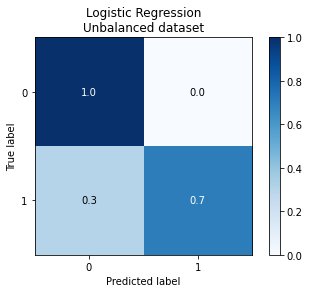

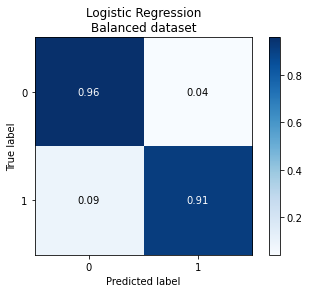

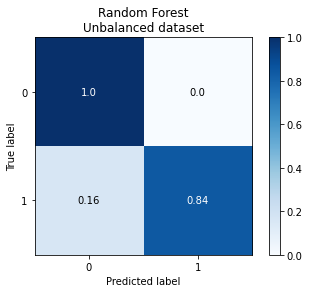

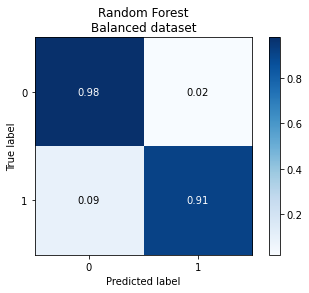

In [21]:
# Plotting confusion matrices
skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True, title='Logistic Regression\nUnbalanced dataset')
skplt.metrics.plot_confusion_matrix(y_val, y_pred_RUS, normalize=True, title='Logistic Regression\nBalanced dataset')
skplt.metrics.plot_confusion_matrix(y_val, y_forest_pred, normalize=True, title='Random Forest\nUnbalanced dataset')
skplt.metrics.plot_confusion_matrix(y_val, y_forest_RUS_pred, normalize=True, title='Random Forest\nBalanced dataset');

#### Classification reports

In [22]:
print('Logistic Regression - Unbalanced:\n', classification_report(y_val, y_pred, digits=4))
print('Logistic Regression - Balanced:\n', classification_report(y_val, y_pred_RUS, digits=4))
print('Random Forest - Unbalanced:\n', classification_report(y_val, y_forest_pred, digits=4))
print('Random Forest - Balanced:\n', classification_report(y_val, y_forest_RUS_pred, digits=4))

Logistic Regression - Unbalanced:
               precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     60417
           1     0.9125    0.6952    0.7892       105

    accuracy                         0.9994     60522
   macro avg     0.9560    0.8476    0.8944     60522
weighted avg     0.9993    0.9994    0.9993     60522

Logistic Regression - Balanced:
               precision    recall  f1-score   support

           0     0.9998    0.9586    0.9788     60417
           1     0.0369    0.9143    0.0710       105

    accuracy                         0.9585     60522
   macro avg     0.5184    0.9364    0.5249     60522
weighted avg     0.9982    0.9585    0.9772     60522

Random Forest - Unbalanced:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     60417
           1     0.9778    0.8381    0.9026       105

    accuracy                         0.9997     60522
   macro avg     0.9887    0.91

#### Area Under the Receiver Operating Characterist Curve - AUROC

In [23]:
# Calculate Area Under the ROC
print("AUC Logistic Regression - Unbalanced: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))
print("AUC Logistic Regression - Balanced: {:.4f}\n".format(roc_auc_score(y_val, y_pred_RUS)))
print("AUC Random Forest - Unbalanced: {:.4f}\n".format(roc_auc_score(y_val, y_forest_pred)))
print("AUC Random Forest - Balanced:: {:.4f}\n".format(roc_auc_score(y_val, y_forest_RUS_pred)))   

AUC Logistic Regression - Unbalanced: 0.8476

AUC Logistic Regression - Balanced: 0.9364

AUC Random Forest - Unbalanced: 0.9190

AUC Random Forest - Balanced:: 0.9461



#### Metrics summary

When we analyse an unbalanced dataset, **accuracy** is not a good metric to evaluate the performance of our model. This occurs because in some cases, even with high accuracy, the number of cases of interest (in this case, fraud) that we are *actually* able to predict can be low.

In these cases, better metrics to look at are the **precision**, the **recall**, and the **AUC ROC** metric.

To be more specific, the **precision** of our model measures our model's ability to avoid labelling a positive case that's actually negative. What this means in our case is: Out of all the transactions that were predicted by our model to be fraudulent, how many were *actual frauds*?

The **recall**, or sensitivity, is the ability of our model to correctly identify all positive cases. Translating to our case here: Out of all the *actual frauds* registered in the dataset, how many of them were detected by our model?

It is easy to perceive which of these cases is more important here. Predicting true positive cases is essential to prevent frauds from happening. Whereas assigning fraud to a regular transaction would only cause a (hopefully) minor inconvenience, and could be easily dealt with by the card owner and the cardholder company.

As for the **AUC**, it is the calculation of the area under a ROC curve (which is a probability curve). A ROC curve plots the *sensitivity* (true positives rate) against *1 - Specificity* (false positives rate). The higher the area under the curve (i.e. the closer to 1 the value is), the better our model is at distinguishing the classes (fraud from normal transactions).

Let's see a summary of the metrics we gathered above.


##### Logistic Regression
|                     | Unbalanced | Balanced |
| ------------------- | ---------- | -------- |
| Precision (class 1) | 0.9125     | 0.0247   |
| Recall (class 1)    | 0.6952     | 0.9143   |
| Accuracy            | 0.9994     | 0.9372   |
| AUROC               | 0.8476     | 0.9258   |


##### Random Forest
|                     | Unbalanced | Balanced |
| ------------------- | ---------- | -------- |
| Precision (class 1) | 0.9778     | 0.0453   |
| Recall (class 1)    | 0.8381     | 0.9048   |
| Accuracy            | 0.9997     | 0.9667   |
| AUROC               | 0.919      | 0.9358   |

We can see that the ***Logistic Regression*** model was much more affected by the unbalanced dataset. With the unbalanced data, it yielded high **precision**, but not so good a **recall** although the **AUC** was not so bad either. By balancing the dataset, we were able to improve true prediction of frauds (increase in **recall** rates), by the cost of also increasing the number of false positives (low **precision** rate). However, in the balanced model the **AUC** also yielded better results.

As for the ***Random Forest*** model, except for **recall** in the balanced dataset, it yielded better classification results, specially the **AUC**. Another aspect is important here. We can see that even with the unbalanced dataset, the Random Forest presented fair results with high **precision** and higher **recall** than the Logistic Regression (although the recall was not as good as with the balanced dataset).

### Model Testing

When we began, we separated our dataset into: training, validation and testing. Now that we built and validated our models, we should test how it performs with a new set of data. For this, we have to prepare the test data in the same way we prepared our training/validation data.

#### Preparing our test data

In [24]:
# Copying df
test_std = test.copy()

# Standardizing and droping old vars
test_std['Std_Time'] = std_scaler.fit_transform(test_std['Time'].values.reshape(-1, 1))
test_std['Std_Amount'] = std_scaler.fit_transform(test_std['Amount'].values.reshape(-1, 1))

test_std.drop(['Time', 'Amount'], axis=1, inplace=True)

In [25]:
# Checking new vars
test_std[['Std_Time', 'Std_Amount']].describe()

,Std_Time,Std_Amount
count,4.272100e+04,4.272100e+04
mean,-1.346322e-16,-5.457819e-17
std,1.000012e+00,1.000012e+00
min,-1.999464e+00,-3.923252e-01
25%,-8.535166e-01,-3.666254e-01
50%,-2.148177e-01,-2.929589e-01
75%,9.361839e-01,-4.531107e-02
max,1.639155e+00,2.327265e+01


In [26]:
# Extracting target
y_test = test_std['Class']
X_test = test_std.drop('Class', axis=1)

#### Making predictions in our test data


In [27]:
# Setting seed
np.random.seed(42)

# Predicting using logistic Regression - Unbalanced
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Predicting using logistic Regression - Balanced
y_pred_RUS = model_RUS.predict(X_test)
y_proba_RUS = model_RUS.predict_proba(X_test)

# Predicting using logistic Regression - Unbalanced
y_forest_pred = forest.predict(X_test)
y_forest_proba = forest.predict_proba(X_test)

# Predicting using logistic Regression - Balanced
y_forest_RUS_pred = forest_RUS.predict(X_test)
y_forest_RUS_proba = forest_RUS.predict_proba(X_test)

#### Evaluating our tests

In [28]:
# Calculating Area Under the ROC and Classification Reports
print('Logistic Regression - Unbalanced:\n', classification_report(y_test, y_pred, digits=4))
print("AUC Logistic Regression - Unbalanced: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

print('Logistic Regression - Balanced:\n', classification_report(y_test, y_pred_RUS, digits=4))
print("AUC Logistic Regression - Balanced: {:.4f}\n".format(roc_auc_score(y_test, y_pred_RUS)))

print('Random Forest - Unbalanced:\n', classification_report(y_test, y_forest_pred, digits=4))
print("AUC Random Forest - Unbalanced: {:.4f}\n".format(roc_auc_score(y_test, y_forest_pred)))

print('Random Forest - Balanced:\n', classification_report(y_test, y_forest_RUS_pred, digits=4))
print("AUC Random Forest - Balanced:: {:.4f}\n".format(roc_auc_score(y_test, y_forest_RUS_pred)))

Logistic Regression - Unbalanced:
               precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     42647
           1     0.8600    0.5811    0.6935        74

    accuracy                         0.9991     42721
   macro avg     0.9296    0.7905    0.8466     42721
weighted avg     0.9990    0.9991    0.9990     42721

AUC Logistic Regression - Unbalanced: 0.7905

Logistic Regression - Balanced:
               precision    recall  f1-score   support

           0     0.9999    0.9570    0.9780     42647
           1     0.0358    0.9189    0.0688        74

    accuracy                         0.9569     42721
   macro avg     0.5178    0.9380    0.5234     42721
weighted avg     0.9982    0.9569    0.9764     42721

AUC Logistic Regression - Balanced: 0.9380

Random Forest - Unbalanced:
               precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     42647
           1     0.9655    0.7568    0.8485       

### Metrics summary

#### Logistic Regression

|                     | Unbalanced | Balanced |
| ------------------- | ---------- | -------- |
| Precision (class 1) | 0.86       | 0.0358   |
| Recall (class 1)    | 0.5811     | 0.9189   |
| Accuracy            | 0.9991     | 0.9569   |
| AUROC               | 0.7905     | 0.938    |

#### Random Forest

|                     | Unbalanced | Balanced |
| ------------------- | ---------- | -------- |
| Precision (class 1) | 0.9655     | 0.066    |
| Recall (class 1)    | 0.7568     | 0.8919   |
| Accuracy            | 0.9995     | 0.9779   |
| AUROC               | 0.8784     | 0.935    |

<br>

Overall, in our test dataset, the **Logistic Regression** model performed better, except when using *unbalanced* data.


### What does it mean?

We have seen that we managed to obtain two overall good prediction models. What does it mean, in practice? Our model is only good when it improves reality. In credit card fraud, that would mean actually predicting and preventing credit card fraud from happening to prevent the owner and the cardholder company from losing money. 

We could, for example, take a look a how our model predicted the actual cases from the test set. Let us see what we have for the first 6 cases in our test data:

In [29]:
# Getting the first 6 predictions of our model
n = 0
while n < 6:
    print('Index = %s, Class = %s, Predicted = %s' % (y_test.index.values[n], y_test.iloc[n], y_forest_RUS_pred[n]))
    n = n + 1

Index = 43428, Class = 1, Predicted = 1
Index = 49906, Class = 0, Predicted = 0
Index = 29474, Class = 0, Predicted = 0
Index = 276481, Class = 0, Predicted = 0
Index = 278846, Class = 0, Predicted = 0
Index = 101565, Class = 0, Predicted = 0


We can see that for all of these cases, our model correctly predicted the outcome. However looking at it in this light would be time-consuming and unfeasible. Good practice tells us that we must align our models with **Key Performance Indicators** (KPIs) to better translate our model to the real world.

#### Fraud KPIs

The [Merchant Fraud Journal](https://www.merchantfraudjournal.com/fraud-prevention-kpi-for-success/) defines 7 KPIs to succesfully prevent fraud from hapenning. They are:

* **Fraud Rate** = These represent fraudulent transactions that would be approved.
* **Incoming Pressure** = All attempted transactions that were fraudulent (blocked + allowed ones).
* **Final Approval Rate** = All approved transactions, regardless of fraud prevention decisions.
* **Precision** = This would be the percentage of frauds among the total number of declined transactions. **(!)**
* **Recall** = The is the percentage of fraudulent transactions declined which were actually frauds. **(!)**
* **Decline Rate** = All declined transactions, out of the total transactions.
* **Good User Approval Rate** = All legitimate transactions, out of all the approved transactions.

<sub> **(!)**: These actually represent the same metrics found in our models. We will calculate them again, as if we did not see any reports beforehand. </sub>

One other good thing to look at would be how much loss of money we could prevent by correctly predicting the frauds. We will call this **Preventable Money Loss**.

From classifying the data and by having information as to the original status of the transcation, we are actually able to see how these KPIs would behave in case the selected model was employed to prevent credit card fraud.

In [30]:
## Preparing data to calculate our KPIs

# Creating dict
predictions = {'index': y_test.index.values,
               'amount': std_scaler.inverse_transform(X_test.Std_Amount.to_numpy().reshape(-1,1)).reshape(-1),
               'class': y_test.to_numpy(),
               'pred_logreg': y_pred,
               'catch_logreg': "",
               'pred_logregRUS': y_pred_RUS,
               'catch_logregRUS': "",
               'pred_rforest': y_forest_pred,
               'catch_rforest': "",
               'pred_rforestRUS': y_forest_RUS_pred,
               'catch_rforestRUS': ""}

# Converting to df
predictions_df = pd.DataFrame(predictions)

# Column names list
pred_columns = ['pred_logreg', 'pred_logregRUS', 'pred_rforest', 'pred_rforestRUS']
catch_columns = ['catch_logreg', 'catch_logregRUS', 'catch_rforest', 'catch_rforestRUS']

# Catching predicted frauds
for i in range(predictions_df.shape[0]):
    for j in range(len(pred_columns)):
        if predictions_df['class'][i] == 1:
            if predictions_df['class'][i] == predictions_df[pred_columns[j]][i]:
                predictions_df.loc[i,catch_columns[j]] = 'Caught'
            else:
                predictions_df.loc[i,catch_columns[j]] = 'Uncaught'
        elif predictions_df['class'][i] == 0 and predictions_df[pred_columns[j]][i] == 1:
            predictions_df.loc[i,catch_columns[j]] = 'Blocked'
        else:
            predictions_df.loc[i,catch_columns[j]] = 'Passed'

predictions_df.head()

,index,amount,class,pred_logreg,catch_logreg,pred_logregRUS,catch_logregRUS,pred_rforest,catch_rforest,pred_rforestRUS,catch_rforestRUS
0,43428,364.19,1,1,Caught,1,Caught,1,Caught,1,Caught
1,49906,520.12,0,0,Passed,0,Passed,0,Passed,0,Passed
2,29474,31.00,0,0,Passed,0,Passed,0,Passed,0,Passed
3,276481,1.50,0,0,Passed,0,Passed,0,Passed,0,Passed
4,278846,0.89,0,0,Passed,0,Passed,0,Passed,0,Passed


Now, we have a dataframe that contains the original amount of the transactions, and whether they were actually frauds or good transactions and how our models predicted them (`pred_` columns). We coded how our models behaved in the `catch_` columns, as the following:

* `Caught` = Frauds that were caught by our model (True Positives). Denoted as: $C$.
* `Uncaught` = Frauds that the model was not able to caught (False Negatives). Denoted as: $U$.
* `Blocked` = Blocked transactions that were not actual frauds (False Positives). Denoted as: $B$.
* `Passed` = Good transactions allowed to pass by our model (True Negatives). Denoted as: $P$.

The total transactions will be denoted as $n$.

And based on that, how would we calculate our KPIs?

* **Fraud Rate** = $ U \over n $
* **Incoming Pressure** = $C + U$
* **Final Approval Rate** = $U + P \over n$ 
* **Precision** = $C \over C + B$ 
* **Recall** = $C \over C + U$ 
* **Decline Rate** = $C + B \over n$
* **Good User Approval Rate** = $P \over P + U$

With this in mind, let us calculate our KPIs for each model:

In [59]:
## Calculating KPIs

# Creating dict
kpis_dict = {'KPI': ['Fraud Rate', 'Incoming Pressure', 'Final Approval Rate', 'Precision', 'Recall', 'Decline Rate', 'Good User Approval Rate'],
             'Logistic Regression (Unbalanced)': ["{:.2%}".format(predictions_df.catch_logreg.value_counts()['Uncaught'] / predictions_df.shape[0]),
                                                  predictions_df.catch_logreg.value_counts()['Caught'] + predictions_df.catch_logreg.value_counts()['Uncaught'],
                                                  "{:.2%}".format((predictions_df.catch_logreg.value_counts()['Uncaught'] + predictions_df.catch_logreg.value_counts()['Passed']) / predictions_df.shape[0]),
                                                  "{:.2%}".format(predictions_df.catch_logreg.value_counts()['Caught'] / (predictions_df.catch_logreg.value_counts()['Caught'] + predictions_df.catch_logreg.value_counts()['Blocked'])),
                                                  "{:.2%}".format(predictions_df.catch_logreg.value_counts()['Caught'] / (predictions_df.catch_logreg.value_counts()['Caught'] + predictions_df.catch_logreg.value_counts()['Uncaught'])),
                                                  "{:.2%}".format((predictions_df.catch_logreg.value_counts()['Caught'] + predictions_df.catch_logreg.value_counts()['Blocked']) / predictions_df.shape[0]),
                                                  "{:.2%}".format(predictions_df.catch_logreg.value_counts()['Passed'] / (predictions_df.catch_logreg.value_counts()['Passed'] + predictions_df.catch_logreg.value_counts()['Uncaught']))],
             'Logistic Regression (Balanced)': ["{:.2%}".format(predictions_df.catch_logregRUS.value_counts()['Uncaught'] / predictions_df.shape[0]),
                                                predictions_df.catch_logregRUS.value_counts()['Caught'] + predictions_df.catch_logregRUS.value_counts()['Uncaught'],
                                                "{:.2%}".format((predictions_df.catch_logregRUS.value_counts()['Uncaught'] + predictions_df.catch_logregRUS.value_counts()['Passed']) / predictions_df.shape[0]),
                                                "{:.2%}".format(predictions_df.catch_logregRUS.value_counts()['Caught'] / (predictions_df.catch_logregRUS.value_counts()['Caught'] + predictions_df.catch_logregRUS.value_counts()['Blocked'])),
                                                "{:.2%}".format(predictions_df.catch_logregRUS.value_counts()['Caught'] / (predictions_df.catch_logregRUS.value_counts()['Caught'] + predictions_df.catch_logregRUS.value_counts()['Uncaught'])),
                                                "{:.2%}".format((predictions_df.catch_logregRUS.value_counts()['Caught'] + predictions_df.catch_logregRUS.value_counts()['Blocked']) / predictions_df.shape[0]),
                                                "{:.2%}".format(predictions_df.catch_logregRUS.value_counts()['Passed'] / (predictions_df.catch_logregRUS.value_counts()['Passed'] + predictions_df.catch_logregRUS.value_counts()['Uncaught']))],
             'Random Forest (Unbalanced)': ["{:.2%}".format(predictions_df.catch_rforest.value_counts()['Uncaught'] / predictions_df.shape[0]),
                                            predictions_df.catch_rforest.value_counts()['Caught'] + predictions_df.catch_rforest.value_counts()['Uncaught'],
                                            "{:.2%}".format((predictions_df.catch_rforest.value_counts()['Uncaught'] + predictions_df.catch_rforest.value_counts()['Passed']) / predictions_df.shape[0]),
                                            "{:.2%}".format(predictions_df.catch_rforest.value_counts()['Caught'] / (predictions_df.catch_rforest.value_counts()['Caught'] + predictions_df.catch_rforest.value_counts()['Blocked'])),
                                            "{:.2%}".format(predictions_df.catch_rforest.value_counts()['Caught'] / (predictions_df.catch_rforest.value_counts()['Caught'] + predictions_df.catch_rforest.value_counts()['Uncaught'])),
                                            "{:.2%}".format((predictions_df.catch_rforest.value_counts()['Caught'] + predictions_df.catch_rforest.value_counts()['Blocked']) / predictions_df.shape[0]),
                                            "{:.2%}".format(predictions_df.catch_rforest.value_counts()['Passed'] / (predictions_df.catch_rforest.value_counts()['Passed'] + predictions_df.catch_rforest.value_counts()['Uncaught']))],
             'Random Forest (Balanced)': ["{:.2%}".format(predictions_df.catch_rforestRUS.value_counts()['Uncaught'] / predictions_df.shape[0]),
                                          predictions_df.catch_rforestRUS.value_counts()['Caught'] + predictions_df.catch_rforestRUS.value_counts()['Uncaught'],
                                          "{:.2%}".format((predictions_df.catch_rforestRUS.value_counts()['Uncaught'] + predictions_df.catch_rforestRUS.value_counts()['Passed']) / predictions_df.shape[0]),
                                          "{:.2%}".format(predictions_df.catch_rforestRUS.value_counts()['Caught'] / (predictions_df.catch_rforestRUS.value_counts()['Caught'] + predictions_df.catch_rforestRUS.value_counts()['Blocked'])),
                                          "{:.2%}".format(predictions_df.catch_rforestRUS.value_counts()['Caught'] / (predictions_df.catch_rforestRUS.value_counts()['Caught'] + predictions_df.catch_rforestRUS.value_counts()['Uncaught'])),
                                          "{:.2%}".format((predictions_df.catch_rforestRUS.value_counts()['Caught'] + predictions_df.catch_rforestRUS.value_counts()['Blocked']) / predictions_df.shape[0]),
                                          "{:.2%}".format(predictions_df.catch_rforestRUS.value_counts()['Passed'] / (predictions_df.catch_rforestRUS.value_counts()['Passed'] + predictions_df.catch_rforestRUS.value_counts()['Uncaught']))]}

kpis_df = pd.DataFrame(kpis_dict)

kpis_df

,KPI,Logistic Regression (Unbalanced),Logistic Regression (Balanced),Random Forest (Unbalanced),Random Forest (Balanced)
0,Fraud Rate,0.07%,0.01%,0.04%,0.02%
1,Incoming Pressure,74,74,74,74
2,Final Approval Rate,99.88%,95.55%,99.86%,97.66%
3,Precision,86.00%,3.58%,96.55%,6.60%
4,Recall,58.11%,91.89%,75.68%,89.19%
5,Decline Rate,0.12%,4.45%,0.14%,2.34%
6,Good User Approval Rate,99.93%,99.99%,99.96%,99.98%


## Conclusions

Here, we executed a basic analysis by using (mostly) default parameters in both machine learning classification models, the Logistic Regression and the Random Forest classifiers. However, we also compared how both models deal with unbalanced data.

As for our data, we could see that there are two apparent peaks in time where the frauds occur. These peaks could be related to specific hours of the day, such as nighttime, that could provide some aditional information for our model. However, we cannot infer the time of day from the provided data as it is.

Regarding our classifications, in the validation phase, we saw that the Random Forest classifier yielded better results. When we classified our test data, we found that the Logistic Regression had better results, especially by reaching over 90% precision with a balanced dataset. Nonetheless, both models had good AUROC results, and were regarded as good models to distinguish correctly between fraudulent and normal transactions.

We can also observe the effect that class proportions have in the training phase of our dataset. It has been demonstrated that the Random Forest classifier provides better results when dealing with unbalanced datasets when compared to the Logistic Regression, especially by reaching higher recall rates concomitantly with high precision rates.

Despite these good results, further improvement can and should be made in these models. In the future, it is important to check and fine-tune these models by changing their hyperparameters appropriately.